<a href="https://colab.research.google.com/github/wuziqin/wuziqin/blob/master/LSTM(07_06_21).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
#import the packages
import math
import statistics 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import scipy
!pip install tensorflow


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline



## 1.   Read in the excel file




In [173]:
# loads the raw data 
data = pd.read_excel("/content/data.xlsx")
data['Date']=pd.to_datetime(data.Date, format='%Y%m', errors='ignore')
data

,Date,Return,Index,D12,E12,tbl,AAA,BAA,lty,Rfree,ppiaco,indpro
0,1926-01-01,-0.001783,12.74,0.607500,1.249,0.0349,0.0482,0.0609,0.037400,0.002908,0.00000,-1.64504
1,1926-02-01,-0.033296,12.18,0.615000,1.248,0.0318,0.0477,0.0602,0.037200,0.002650,-1.12360,0.00000
2,1926-03-01,-0.057708,11.46,0.622500,1.248,0.0314,0.0479,0.0605,0.037100,0.002617,-1.70455,1.25555
3,1926-04-01,0.038522,11.72,0.630000,1.247,0.0308,0.0474,0.0598,0.036800,0.002567,0.00000,0.00000
4,1926-05-01,0.013623,11.81,0.637500,1.246,0.0317,0.0471,0.0586,0.036900,0.002642,0.00000,-0.82666
...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2018-08-01,0.032938,2901.52,52.338996,130.390,0.0203,0.0388,0.0477,0.028891,0.001692,-0.44053,0.80311
1112,2018-09-01,0.005138,2913.98,52.338996,130.390,0.0213,0.0398,0.0488,0.030042,0.001775,0.09833,0.13723
1113,2018-10-01,-0.068409,2711.74,53.748178,132.390,0.0225,0.0414,0.0507,0.031523,0.001875,0.49116,0.22029
1114,2018-11-01,0.019980,2760.17,53.748178,132.390,0.0233,0.0422,0.0522,0.031170,0.001942,-1.12414,0.53695





## 2.   Calculate the 12 predictors



In [174]:
#construct the predictors
rfLag   = data["Rfree"]
ppigLag = data["ppiaco"]
ipgLag  = data["indpro"]

#Python's Indexes start from ZERO
startObs = 11
stock = []
date = []

for i in range(startObs,len(data)):
    a = data.Return[i]
    b = rfLag[i-1]
    stockC = a - b
    
    stock.append(stockC)
    
    dateC = data.Date[i]
    date.append(dateC)

stock = pd.DataFrame(stock)
date = pd.DataFrame(date)
stock = stock.multiply(100.0)


#rx
rx=pd.concat([date, stock], axis=1)
new_col = ['Date', 'stock']
rx.columns = new_col
rx=rx.reset_index(drop=True)
date['Date']=pd.to_datetime(data.Date, format='%Y%m', errors='ignore')


#vol, bill, bond, ma0112, ma0312, mom06, debug
vol = []
bill = []
bond=[]
ma0112 = []
ma0312 = []
mom06=[]
debug = []

for t in range(startObs,len(data)):
    volC=math.sqrt((math.pi)/2)*(math.sqrt(12))*(np.mean(abs(data.Return[(t-(startObs)-0):t+1])))
    vol.append(volC)
    
    billC = data.tbl[t-0]-np.mean(data.tbl[(t-(startObs)-0):t+1])
    bill.append(billC)
    
    bondC = data.lty[t-0]-np.mean(data.lty[(t-(startObs)-0):t+1])
    bond.append(bondC)
    
    ma0112C = int(data.Index[t]>np.mean(data.Index[(t-(startObs)-0):t+1]))
    ma0112.append(ma0112C)
    
    ma0312C = int(np.mean(data.Index[(t-2):t+1])>np.mean(data.Index[(t-(startObs)-0):t+1]))

   
    ma0312.append(ma0312C)
    
    mom06C = int(data.Index[t]>data.Index[t-6])
    mom06.append(mom06C)
    
vol = pd.DataFrame(vol)
bill = pd.DataFrame(bill)
bond = pd.DataFrame(bond)
ma0112 = pd.DataFrame(ma0112)
ma0312 = pd.DataFrame(ma0312)
mom06 = pd.DataFrame(mom06)
debug = pd.DataFrame(debug)


#de, ep, term, credit, ppig, ipg
date = []
dp = []
ep = []
term = []
credit = []
ppig = []
ipg = []


for t in range(startObs,len(data)):
    dateC = data.Date[t]
    date.append(dateC)
    
    dpC = math.log(data.D12[t]/data.Index[t])
    dp.append(dpC)

    epC = math.log(data.E12[t]/data.Index[t])
    ep.append(epC)
    
    
    termC = 100.0*(data.lty[t]-data.tbl[t])
    term.append(termC)

    creditC = 100.0*(data.AAA[t]-data.lty[t])
    credit.append(creditC)    
    
    
for m in range(10,len(data)-1):
    ipgC = ipgLag[m]
    ipg.append(ipgC)

    ppigC = ppigLag[m]
    ppig.append(ppigC)


date = pd.DataFrame(date)
dp = pd.DataFrame(dp)
ep = pd.DataFrame(ep)
term = pd.DataFrame(term)
credit = pd.DataFrame(credit)
ppig = pd.DataFrame(ppig)
ipg = pd.DataFrame(ipg)
vol = vol.multiply(100.0)
bill = bill.multiply(100.0)
bond = bond.multiply(100.0)

predictor = pd.concat([date, dp, ep, vol, bill, bond, term, credit, ppig, ipg, ma0112, ma0312, mom06],axis=1,ignore_index=True)
predictor.columns = ['Date', 'dp', 'ep', 'vol', 'bill', 'bond', 'term', 'credit', 'ppig', 'ipg', 'ma0112', 'ma0312', 'mom06']
predictor

,Date,dp,ep,vol,bill,bond,term,credit,ppig,ipg,ma0112,ma0312,mom06
0,1926-12-01,-2.973012,-2.386837,13.320052,-0.162500,-0.140000,0.470000,1.140000,-0.58480,-0.39851,1,1,1
1,1927-01-01,-2.942374,-2.374773,13.360827,0.019167,-0.150833,0.280000,1.150000,-0.58824,-0.40010,1,1,1
2,1927-02-01,-2.979535,-2.430353,13.803164,0.070000,-0.170000,0.180000,1.200000,-2.95858,-0.40171,1,1,1
3,1927-03-01,-2.976535,-2.445079,11.980268,-0.025000,-0.296667,0.110000,1.310000,1.21951,0.80666,1,1,1
4,1927-04-01,-2.984225,-2.471309,11.057640,0.139167,-0.247500,-0.060000,1.250000,-0.60241,1.20031,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,2018-08-01,-4.015248,-3.102460,11.303303,0.460000,0.125591,0.859130,0.990870,0.04897,0.44494,1,1,1
1101,2018-09-01,-4.019533,-3.106745,10.763786,0.468333,0.206154,0.874211,0.975789,-0.44053,0.80311,1,1,1
1102,2018-10-01,-3.921036,-3.019594,12.364790,0.490000,0.309026,0.902273,0.987727,0.09833,0.13723,0,1,1
1103,2018-11-01,-3.938738,-3.037295,11.952011,0.478333,0.230670,0.787000,1.103000,0.49116,0.22029,1,1,1





## 3.  Build the dataset



In [ ]:
# remove the first row and last row
predictor.drop(axis=0, index=0, inplace=True)
predictor = predictor[:-1]


In [176]:
#date & rx
startSample =pd.Timestamp('1927-01-01')
rx=rx[rx['Date']>=startSample]


date.columns = ['Date']
date = date[date['Date']>=startSample]


In [177]:

endIn = pd.Timestamp('1927-01-01')
endInIndex = date.Date[date.Date == endIn].index.values
endInIndex = endInIndex[0]



In [178]:
actual = rx.stock[endInIndex:]
actual.reset_index(drop=True, inplace=True) 

date = date.Date[endInIndex:]
date.reset_index(drop=True, inplace=True) 



In [179]:
actual = pd.DataFrame(actual)
tableActual = pd.concat([date,actual],axis = 1)
tableActual.columns = ['Date', 'return']
tableActual.to_csv("tableActual.csv",index = False)


In [180]:
df_final = pd.merge(left=predictor, right=tableActual, how='inner',
               left_on='Date', right_on='Date')

In [181]:
df_final.rename(columns={'return':'return_1_month_after'}, inplace = True)
df_final


,Date,dp,ep,vol,bill,bond,term,credit,ppig,ipg,ma0112,ma0312,mom06,return_1_month_after
0,1927-02-01,-2.979535,-2.430353,13.803164,0.070000,-0.170000,0.180000,1.200000,-2.95858,-0.40171,1,1,1,4.283033
1,1927-03-01,-2.976535,-2.445079,11.980268,-0.025000,-0.296667,0.110000,1.310000,1.21951,0.80666,1,1,1,0.458233
2,1927-04-01,-2.984225,-2.471309,11.057640,0.139167,-0.247500,-0.060000,1.250000,-0.60241,1.20031,1,1,1,1.035433
3,1927-05-01,-3.025963,-2.531446,12.820695,0.065833,-0.272500,-0.060000,1.300000,-1.21212,-2.37215,1,1,1,5.952800
4,1927-06-01,-3.007309,-2.531330,11.516150,-0.205833,-0.174167,0.270000,1.240000,-0.61350,0.80993,1,1,1,-2.314500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,2018-07-01,-3.985434,-3.072646,10.192575,0.475000,0.164603,0.929048,0.980952,0.49213,0.75146,1,1,0,3.556067
1098,2018-08-01,-4.015248,-3.102460,11.303303,0.460000,0.125591,0.859130,0.990870,0.04897,0.44494,1,1,1,3.130467
1099,2018-09-01,-4.019533,-3.106745,10.763786,0.468333,0.206154,0.874211,0.975789,-0.44053,0.80311,1,1,1,0.344633
1100,2018-10-01,-3.921036,-3.019594,12.364790,0.490000,0.309026,0.902273,0.987727,0.09833,0.13723,0,1,1,-7.018400





## 4.   Plot the dataset



Text(0.5, 1.0, 'excess return')

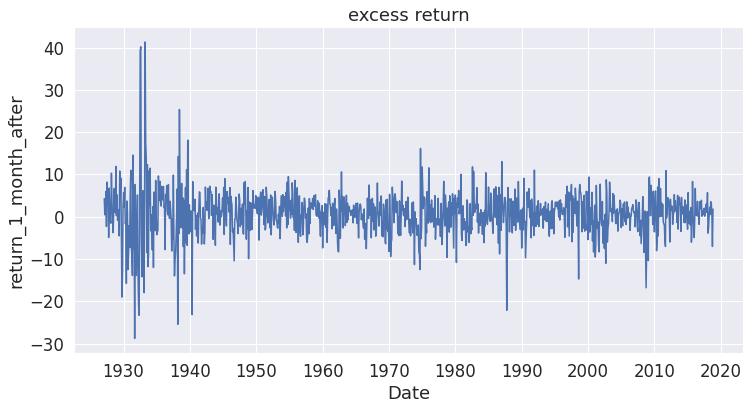

In [182]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_final.Date, y=df_final['return_1_month_after'], data=df_final).set_title("excess return")



## 5.   Separate the features and label



In [183]:

x=df_final.iloc[:,1:13]
y=df_final.iloc[:,13]
y = pd.DataFrame(y)






## 6.   Split the training dataset and test dataset



In [184]:
train_x=x.iloc[0:900,:]
test_x=x.iloc[900:,:]

In [185]:
train_y=y.iloc[0:900,:]
test_y=y.iloc[900:,:]

In [186]:
trainx = np.array(train_x)
trainy= np.array(train_y)

In [187]:
testx = np.array(test_x)
testy= np.array(test_y)

In [188]:
#translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(trainx)
X_test = sc.fit_transform(testx)
y_train = sc.fit_transform(trainy)
y_test = sc.fit_transform(testy)

In [189]:
X_train = X_train.reshape((len(X_train), 12, 1))
X_test  = X_test.reshape((len(X_test), 12, 1))

In [190]:
X_train.shape

(900, 12, 1)

In [191]:
X_test.shape

(202, 12, 1)

In [192]:
y_train.shape

(900, 1)

In [193]:
y_test.shape

(202, 1)




## 7.   implement the LSTM model



In [194]:
import tensorflow as tf
from tensorflow.keras import layers

In [195]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=15, return_sequences=True,
                  input_shape=(12,1)))
model.add(layers.LSTM(units=15, return_sequences=True,
                  ))
model.add(layers.LSTM(units=15))
model.add(layers.Dense(units=1))
model.add(layers.Dense(units=1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 12, 15)            1020      
_________________________________________________________________
lstm_16 (LSTM)               (None, 12, 15)            1860      
_________________________________________________________________
lstm_17 (LSTM)               (None, 15)                1860      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 16        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2         
Total params: 4,758
Trainable params: 4,758
Non-trainable params: 0
_________________________________________________________________


In [196]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [197]:
history = model.fit(X_train, y_train, epochs=10, batch_size=20)

Epoch 1/10
45/45 [==============================] - 5s 10ms/step - loss: 0.0370
Epoch 2/10
45/45 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 3/10
45/45 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 4/10
45/45 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 5/10
45/45 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 6/10
45/45 [==============================] - 1s 11ms/step - loss: 0.0065
Epoch 7/10
45/45 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 8/10
45/45 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 9/10
45/45 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 10/10
45/45 [==============================] - 1s 12ms/step - loss: 0.0064





## 8.   Visualize the result



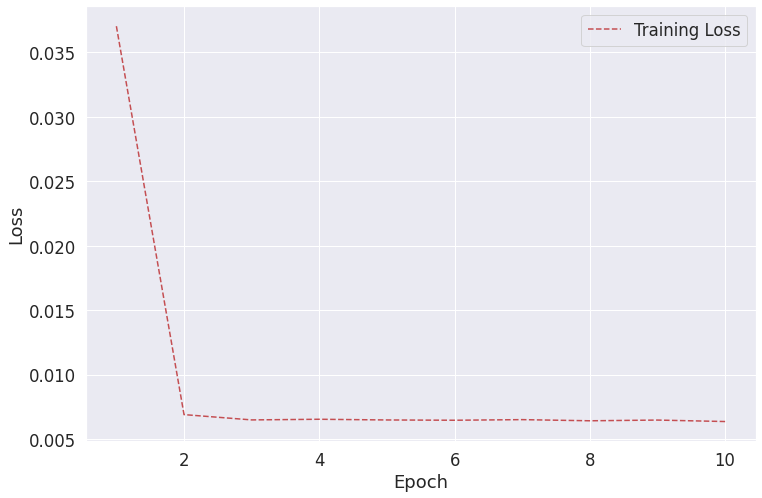

In [198]:
#plot the loss
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

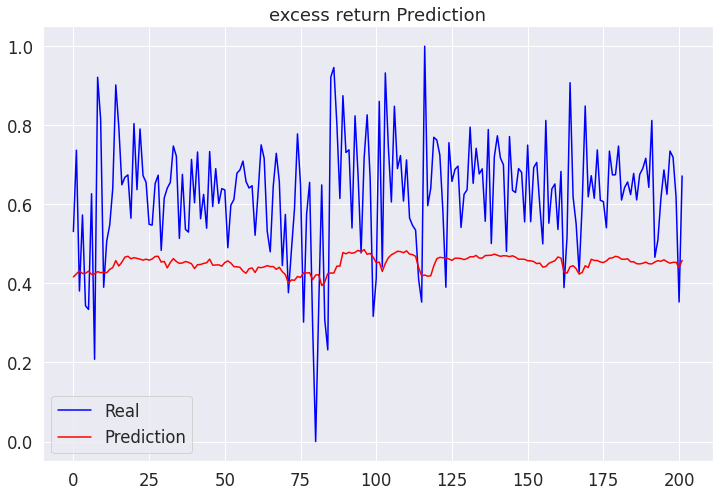

In [199]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('excess return Prediction')
plt.legend()
plt.show()




## 9.   Calculate the R Squared



In [200]:
!pip install -U scikit-learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [201]:

print('R2 Score: ', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

R2 Score:  -1.4542026719659065
MAE:  0.19772076553749235
